Notebook for model (version 2) with transformed data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os

Mounted at /content/drive


In [ ]:
## Imports

%matplotlib inline
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pydantic import BaseModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import random
import cv2

In [ ]:
## Set up

# Paths
#data_path_arrays = 'carseg_data/arrays'

data_path_arrays = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/carseg_data_3/arrays_og'
backgrounds_path = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/carseg_data_3/landscapes_npy'

# Class label map color (assume class labels have been mapped to 0-9)
class Label(BaseModel):
    class_value: int
    color: tuple
    car_part: str

class_values = range(0, 10)
colors = [(255, 255, 255), (255, 165, 0), (0, 128, 0), (255, 255, 0), (0, 255, 255),
          (128, 0, 128), (144, 238, 144), (0, 0, 255), (255, 192, 203), (0, 0, 0)]
car_parts = ["background", "hood", "front door", "rear door", "frame", "rear quater panel", "trunk lid", "fender", "bumper", "rest of car"]

classes = [Label(class_value = cv, color=c, car_part=cp) for cv, c, cp in zip(class_values, colors, car_parts)]

class_to_color = {c.class_value : c.color for c in classes}

# class_to_color = {
#     0: (255, 255, 255),  # White (Background)
#     1: (255, 165, 0),  # Orange (Hood)
#     2: (0, 128, 0),    # Dark Green (Front door)
#     3: (255, 255, 0),  # Yellow (Rear door)
#     4: (0, 255, 255),  # Cyan (Frame)
#     5: (128, 0, 128),  # Purple (Rear quarter panel)
#     6: (144, 238, 144),  # Light Green (Trunk lid)
#     7: (0, 0, 255),    # Blue (Fender)
#     8: (255, 192, 203),  # Pink (Bumper)
#     9: (0, 0, 0)      # Black (Rest of the car)
# }


In [ ]:
## Utlilities

def plot_image(image, grayscale=False):
    # Plots a single image on rgb 0-255 scale
    if torch.is_tensor(image):
        image = image.detach().cpu().permute((1, 2, 0)).numpy()
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        cmap = 'gray' if grayscale else None
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.show()


def segment_image(image, labels):
    # Segments an image based on class labels using color map
    # Returns segmented image as tensor
    if torch.is_tensor(image):
        # Convert tensor to numpy arrays
        image = image.detach().cpu().permute(1, 2, 0).numpy()
        labels = labels.detach().cpu().numpy()

    # Create (rows, cols, 3) array
    segmented_image = np.zeros(image.shape[:2]+(3,))

    # Color the pixels based on the class values
    # Excluding class 0 and class 90 if want to include background and rest of the car
    for class_value, color in class_to_color.items():
        #if class_value != 0 and class_value != 90:
        segmented_image[labels == class_value] = color

    # If want to include background and rest of the car
    # segmented_image[label == 0] = image[label == 0]
    # segmented_image[label == 90] = image[label == 90]

    # Convert to tensor
    segmented_image = torch.from_numpy(segmented_image).permute(2, 0, 1).long()

    return segmented_image

def plot_grid_segmented_images(images, labels, grayscale=False):
    # Plots a grid of segmented images (tensors)
    segmented_images = []
    for image, label in zip(images, labels):
        segmented_image = segment_image(image, label)
        segmented_images.append(segmented_image)

    plot_image(torchvision.utils.make_grid(segmented_images, nrow=4), grayscale=grayscale)


In [ ]:
## Transform images

# Convert to grayscale since there should be no benifit (I think) by using colors
# for segmenting the car parts (most of the time the car is made of the same color
# anyways so...)

grayscale = True
skip_rest_of_car = False
image_size = (256,256)


def add_gaussian_noise(image, mean=0, std=0.4):
    noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image


def adjust_brightness_contrast(image, brightness_factor=0.2, contrast_factor=0.2):
    # Adjust brightness and contrast using OpenCV
    image = cv2.convertScaleAbs(image, alpha=1 + brightness_factor, beta=0)
    image = cv2.addWeighted(image, 1 + contrast_factor, np.zeros_like(image), 0, 0)

    return image


def transform(image, label):
    # Function to transform data (training and testing)

    #image = adjust_brightness_contrast(image)

    # Convert to grayscale
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    # image = cv2.resize(image, image_size, interpolation=cv2.INTER_LINEAR)
    # label = cv2.resize(label, image_size, interpolation=cv2.INTER_NEAREST)
    # NOT NECESARRY WHEN NOT AUGMENTING A CERTAIN WAY

    # Add channel dimension if grayscale
    if grayscale:
        image = np.expand_dims(image, axis=-1)

    return image, label


def augment(image, label):
    # Function to augment data (training data)

    # # Add gaussian noise to image
    # image = add_gaussian_noise(image)

    # # Randomly scale the image and label
    # scale_x = random.uniform(1.0, 1.2)
    # scale_y = random.uniform(1.0, 1.2)
    # image = cv2.resize(image, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
    # label = cv2.resize(label, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_NEAREST)

    # # Randomly crop the image and label
    # final_shape = image_size
    # rows, cols = image.shape[:2]
    # x = random.randint(0, cols - final_shape[1])
    # y = random.randint(0, rows - final_shape[0])
    # image = image[y:y + final_shape[0], x:x + final_shape[1]]
    # label = label[y:y + final_shape[0], x:x + final_shape[1]]

    # # Randomly adjust the color of the image
    # if not grayscale:
    #     r_adjust = random.uniform(0.5, 1.5)
    #     g_adjust = random.uniform(0.5, 1.5)
    #     b_adjust = random.uniform(0.5, 1.5)
    #     image[:, :, 0] = image[:, :, 0] * r_adjust
    #     image[:, :, 1] = image[:, :, 1] * g_adjust
    #     image[:, :, 2] = image[:, :, 2] * b_adjust
    #     image[image > 255] = 255
    #     image[image < 0] = 0

    # Flip the image and label horizontally with a 50% chance
    if random.choice([True, False]):
        image = cv2.flip(image, 1)  # Horizontal flip
        label = cv2.flip(label, 1)  # Horizontal flip for label

    # # Flip the image and label vertically with a 50% chance
    # if random.choice([True, False]):
    #     image = cv2.flip(image, 0)  # Vertical flip
    #     label = cv2.flip(label, 0)  # Vertical flip for label

    # Rotate the image and label slightly (up to +/- 15 degrees)
    angle = random.uniform(-15, 15)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR)
    label = cv2.warpAffine(label, rotation_matrix, (cols, rows), flags=cv2.INTER_NEAREST)

    return image, label


def remove_rest_of_car(labelled_image):
    rest_of_car_label = 9
    labelled_image[labelled_image == rest_of_car_label] = 0
    return labelled_image


In [ ]:
## Add backgrounds to cad images

#backgrounds_path = 'carseg_data/landscapes_npy'
#backgrounds_files = random.sample([file for file in os.listdir(backgrounds_path)], 100)   # only use subset of 100 backgrounds to speed up training

def add_background(image, mask):
    # Function that adds a random background to an image with mask
    # bg_filename = f"{random.randint(1, 4315)}.npy"
    # bg_image_path = os.path.join(backgrounds_path, bg_filename)
    # print(bg_image_path)
    # background = np.load(bg_image_path)
    #background_file = random.choice(backgrounds_files)
    background_file = f"{random.randint(1, 400)}.npy"   # TODO: spurning hvort við viljum velja úr öllum bakgrunnum - kannski of ólíkt?
    background = np.load(os.path.join(backgrounds_path, background_file))
    #background = cv2.resize(background, image_size, interpolation=cv2.INTER_LINEAR)
    background_pixels = (mask == 0)
    image[background_pixels] = background[background_pixels]
    return image

#car_img = np.load('carseg_data/arrays/black_5_doors_0002.npy')
#img = car_img[:,:,:3]
#mask = car_img[:,:,3]
#plot_image(img)
#img = add_background(img, mask)
#plot_image(img)

In [ ]:
## Segmented image data

#num_cad_img = 800   # number of cad images for black and orange, respectively
num_real_duplicates = 28   # number of copy's of real images   (~28 if we use all black and orange cad to have balance)
test_idx = np.arange(1,31)
test_ids = [f"photo_00{i:02d}.npy" for i in test_idx]
real_image_pattern = re.compile(r'.*photo.*')
black_cad_pattern = re.compile(r'.*black.*')
orange_cad_pattern = re.compile(r'.*orange.*')

class SegmentedImageDataset(TensorDataset):
    def __init__(self, data_folder_arrays, train, transform=None):
        self.data_folder = data_folder_arrays
        self.data_files = os.listdir(data_folder_arrays)
        self.real_single = []
        self.real_duplicates = []
        self.black = []
        self.orange = []
        self.train = train
        self.transform = transform
        if self.train:
            # Exclude the test filenames to create the training dataset
            self.data_files = [file for file in self.data_files if file not in test_ids]
            # All real images of cars
            self.real_single = [file for file in self.data_files if real_image_pattern.match(file)]
            self.real_duplicates = []
            # Create num_real_dupclicates duplicates of the real images (to balance dataset but then will be augmented)
            for i in range(num_real_duplicates):
                self.real_duplicates.extend(self.real_single)
            # num_cad_image random black cad images and num_cad_image random orange cad images
            self.black = [file for file in self.data_files if black_cad_pattern.match(file)]
            #self.black = random.sample(self.black, num_cad_img)
            self.orange = [file for file in self.data_files if orange_cad_pattern.match(file)]
            #self.orange = random.sample(self.orange, num_cad_img)
            # Concatenate
            self.data_files = self.real_duplicates + self.black + self.orange
        else:
            # Include only the test filenames for the test dataset
            self.data_files = [file for file in self.data_files if file in test_ids]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        file_name = os.path.join(self.data_folder, self.data_files[idx])
        image_data = np.load(file_name)
        image = image_data[:,:,:3]
        class_labels = image_data[:,:,3]
        class_labels = class_labels//10   # map class labels to 0-9
        # Add random background to image in train dataset
        if self.train:
            image = add_background(image, class_labels)
        # Augment training data
        if self.train:
            image, class_labels = augment(image, class_labels)
        # Transform (all data)
        if self.transform:
            image, class_labels = self.transform(image, class_labels)

        # min-max normalization for the image
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        if skip_rest_of_car:
            class_labels = remove_rest_of_car(class_labels)

        return torch.from_numpy(image).permute(2, 0, 1).float(), torch.tensor(class_labels).long()

    def split_train_validation(self, validation_split):
        # Function to split data into training and validation sets
        num_val_samples_real_single = int(validation_split*len(self.real_single))
        num_val_samples_black = int(validation_split*len(self.black))
        num_val_samples_orange = int(validation_split*len(self.orange))

        random.shuffle(self.real_single)
        random.shuffle(self.black)
        random.shuffle(self.orange)

        # Need to make sure that we don't take duplicates for train and validation (because we are making copy's of real images)
        real_train_file_unique = self.real_single[:-num_val_samples_real_single]
        real_val_file_unique = self.real_single[-num_val_samples_real_single:]
        real_train = [file for file in self.real_duplicates if file in real_train_file_unique]
        real_val = [file for file in self.real_duplicates if file in real_val_file_unique]
        # Same for CAD images (since we can't just split the self.data_files list anymore)
        black_train_file_unique = self.black[:-num_val_samples_black]
        black_val_file_unique = self.black[-num_val_samples_black:]
        black_train = [file for file in self.black if file in black_train_file_unique]
        black_val = [file for file in self.black if file in black_val_file_unique]
        orange_train_file_unique = self.orange[:-num_val_samples_orange]
        orange_val_file_unique = self.orange[-num_val_samples_orange:]
        orange_train = [file for file in self.orange if file in orange_train_file_unique]
        orange_val = [file for file in self.orange if file in orange_val_file_unique]

        return real_train+black_train+orange_train, real_val+black_val+orange_val


batch_size = 16
num_workers = 8
validation_split = 0.1

train_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True, transform=transform)
validation_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True, transform=transform)
test_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=False, transform=transform)
train_dataset.data_files, validation_dataset.data_files = train_dataset.split_train_validation(validation_split)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

6052
647
30


In [ ]:
print('Training data:')
images_train, masks_train = next(iter(train_dataloader))
plot_image(torchvision.utils.make_grid(images_train, nrow=4), grayscale=grayscale)

print('Validation data:')
images_val, masks_val = next(iter(validation_dataloader))
plot_image(torchvision.utils.make_grid(images_val, nrow=4), grayscale=grayscale)

print('Testing data:')
images_test, masks_test = next(iter(test_dataloader))
plot_image(torchvision.utils.make_grid(images_test, nrow=4), grayscale=grayscale)

Output hidden; open in https://colab.research.google.com to view.

Training data:


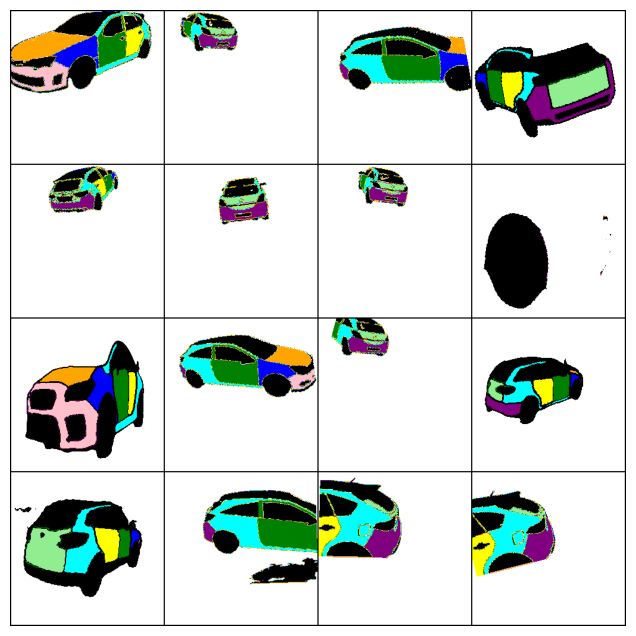

Validation data:


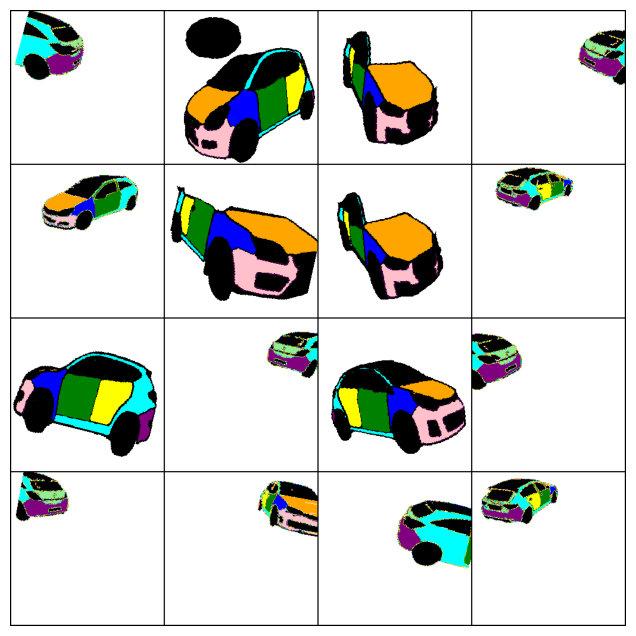

Testing data:


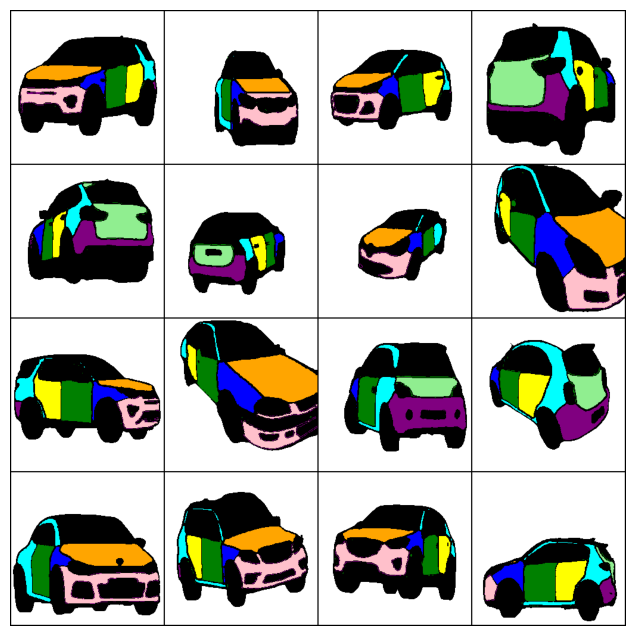

In [ ]:
print('Training data:')
plot_grid_segmented_images(images_train, masks_train)

print('Validation data:')
plot_grid_segmented_images(images_val, masks_val)

print('Testing data:')
plot_grid_segmented_images(images_test, masks_test)

In [ ]:
# TODO: mynd neðst í vinstra horni er léleg í test gögnum... (kannski taka hana út eða replace-a með gömul því hún var betri minnir mig
# þetta gæti nefnilega haft mikil áhrif á niðurstöðuna sem við fáum úr test)

In [ ]:
##bigger model

# STÆKKAÐI AÐEINS (og meira og meira)
class UNet_bigger(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.5):
        super(UNet_bigger, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.enc5 = self.conv_block(512, 1024)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(1024, 2048, num_layers=5)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(2048, 1024)
        self.up2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(256, 128)
        self.up5 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec5 = self.conv_block(128, 64)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)
        self.dropout3 = nn.Dropout(dropout_p)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        p1 = self.dropout1(p1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        p2 = self.dropout1(p2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)
        p3 = self.dropout1(p3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)
        p4 = self.dropout1(p4)

        c5 = self.enc5(p4)
        p5 = self.pool(c5)
        p5 = self.dropout1(p5)

        # Bottleneck
        bottleneck = self.bottleneck(p5)

        # Expanding path
        up1 = self.up1(bottleneck)
        merge1 = torch.cat([up1, c5], dim=1)
        d1 = self.dec1(merge1)
        d1 = self.dropout1(d1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c4], dim=1)
        d2 = self.dec2(merge2)
        d2 = self.dropout1(d2)

        up3 = self.up3(d2)
        merge3 = torch.cat([up3, c3], dim=1)
        d3 = self.dec3(merge3)
        d3 = self.dropout1(d3)

        up4 = self.up4(d3)
        merge4 = torch.cat([up4, c2], dim=1)
        d4 = self.dec4(merge4)
        d4 = self.dropout1(d4)

        up5 = self.up5(d4)
        merge5 = torch.cat([up5, c1], dim=1)
        d5 = self.dec5(merge5)
        d5 = self.dropout1(d5)

        out = self.out(d5)
        return out

    def conv_block(self, in_channels, out_channels, num_layers=2):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)


class UNet_big(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.5):
        super(UNet_big, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(128, 64)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)
        self.dropout3 = nn.Dropout(dropout_p)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        p1 = self.dropout1(p1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        p2 = self.dropout1(p2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)
        p3 = self.dropout1(p3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)
        p4 = self.dropout1(p4)

        # Bottleneck
        bottleneck = self.bottleneck(p4)

        # Expanding path
        up1 = self.up1(bottleneck)
        merge1 = torch.cat([up1, c4], dim=1)
        d1 = self.dec1(merge1)
        d1 = self.dropout1(d1)


        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c3], dim=1)
        d2 = self.dec2(merge2)
        d2 = self.dropout1(d2)

        up3 = self.up3(d2)
        merge3 = torch.cat([up3, c2], dim=1)
        d3 = self.dec3(merge3)
        d3 = self.dropout1(d3)

        up4 = self.up4(d3)
        merge4 = torch.cat([up4, c1], dim=1)
        d4 = self.dec4(merge4)
        d4 = self.dropout1(d4)

        out = self.out(d4)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

# smaller model
## Model

import torch
import torch.nn as nn

# JUST ADDED DROPOUT TO SMALL MODEL
class UNet_small(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.5):
        super(UNet_small, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #self.bottleneck = self.conv_block(128, 256)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64 + 32, 32)

        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)
        self.dropout3 = nn.Dropout(dropout_p)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        p1 = self.dropout1(p1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        p2 = self.dropout1(p2)

        c3 = self.enc3(p2)
        c3 = self.dropout1(c3)

        #bottleneck = self.bottleneck(p3)

        # Expanding path
        up1 = self.up1(c3)
        merge1 = torch.cat([up1, c2], dim=1)
        d1 = self.dec1(merge1)
        d1 = self.dropout1(d1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c1], dim=1)
        d2 = self.dec2(merge2)
        d2 = self.dropout1(d2)

        out = self.out(d2)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


# Create the model
# model = UNet_bigger(in_channels=3, out_channels=10)
# print(model)


In [ ]:
# ## Custom loss functions - (NOT WORKING ATM)

# # TODO: nota þetta loss í staðinn fyrir það sem halldór er með (getum notað vigtir hér líka!)
# # En fyrst þarf ég að finna út úr afhverju módelin sökka eftir að ég notaði augmentation/transformation...

# # https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

# # En er ekki alltaf sama vesen með að inputs eru bara tölur á bilinu 0-1 (ef við notum sigmoid en targets eru
# # class labesl sem eru discrete 0-9...???) - ef ég nota argmax þá aftengjumst við computational graph og
# # allt fer í rugl

# # ATH. þettaa er binary!!
# class DiceBCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceBCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)

#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         Dice_BCE = BCE + dice_loss

#         return Dice_BCE

# class IoULoss(nn.Module):
#     def __init__(self, num_classes, smooth=1e-6):
#         super(IoULoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, logits, targets):
#         #print(logits.grad_fn)
#         # Apply softmax to get class probabilities
#         probs = F.softmax(logits, dim=1)
#         #print(probs.grad_fn)

#         # Kannski ætti ég líka að one-hot encode-a targets...
#         # Já held að þetta sé gert þannig venjulega í flestum loss functions...

#         # Calculate IoU for each class
#         iou_sum = 0.0
#         for i in range(self.num_classes):
#             true_class = targets == i
#             pred_class = probs[:, i, :, :]
#             intersection = torch.sum(true_class.float() * pred_class)
#             union = torch.sum(true_class.float()) + torch.sum(pred_class) - intersection
#             iou = (intersection + self.smooth) / (union + self.smooth)
#             iou_sum += iou

#         # Average IoU over all classes
#         average_iou = iou_sum / self.num_classes

#         # Convert IoU to IoU loss
#         iou_loss = 1.0 - average_iou

#         return iou_loss

#     # def forward(self, outputs, targets):
#     #     print(outputs.grad_fn)
#     #     outputs = torch.argmax(outputs, dim=1).float()   # get class value from logits
#     #     #outputs.requires_grad=True
#     #     print(outputs.grad_fn)
#     #     iou_sum = 0.0
#     #     for i in range(self.num_classes):
#     #         true_class = (targets== i)
#     #         pred_class = (outputs == i)
#     #         intersection = torch.sum(true_class * pred_class)
#     #         union = torch.sum(true_class ) + torch.sum(pred_class) - intersection
#     #         iou = (intersection + self.smooth) / (union + self.smooth)
#     #         iou_sum += iou

#     #     return Variable(1-iou_sum/self.num_classes, requires_grad=True)


# class DiceLoss(nn.Module):
#     def __init__(self, num_classes, smooth=1e-6):
#         super(DiceLoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, outputs, targets):
#         dice_sum = 0.0
#         for i in range(self.num_classes):
#             true_class = (targets == i)
#             pred_class = (outputs == i)
#             intersection = torch.sum(true_class * pred_class)
#             union = torch.sum(true_class) + torch.sum(pred_class)
#             dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
#             dice_sum += dice

#         return 1-dice_sum/self.num_classes



In [ ]:
## Focal loss

# https://amaarora.github.io/posts/2020-06-29-FocalLoss.html
# https://arxiv.org/abs/1708.02002

# A bit confused about how it is supposed to be for multiclass problems...
# alpha and weights is the confusing part...

# So here we use weighted CE loss and then use the gamma factor for
# focusing on handling hard examples to classify (and basically
# not using alpha or instead using the weights in CE)

class FocalLossMultiClass(torch.nn.Module):
    def __init__(self, weights=None, gamma=2, reduction='mean'):
        super(FocalLossMultiClass, self).__init__()
        self.weights = weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weights)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss



In [ ]:
## Model configuration

# Constants
num_classes = 9 if skip_rest_of_car else 10
num_channels = 1 if grayscale else 3

# Class weights


# Loss


In [ ]:
## Custom loss function (Halldór)
import sys
# Import custom loss function
sys.path.append(os.path.join('/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/github/Halldor'))
from bi_tempered_loss import *

def calculate_class_weights(num_classes=10):

    # Calculate fractions -> weights
    fractions = {c: np.array([]) for c in range(0,num_classes)}   # use num_classes if we decide to skip rest of the car
    pixels_per_img = image_size[0]*image_size[1]

    # Process each image in train dataset
    for images, masks in train_dataloader:
        images = images.detach().cpu().numpy()
        masks = masks.detach().cpu().numpy()
        for image, mask in zip(images, masks):
            # # Count the pixels that are not background for the current image
            # non_background_pixels = np.sum(mask != 0)

            # Calculate the fraction for each segment in the current image
            for segment in range(0,num_classes):
                segment_pixels = np.sum(mask == segment)
                fraction = segment_pixels / pixels_per_img

                # Append the fraction to the list for the segment
                fractions[segment] = np.append(fractions[segment], fraction)

    # Now 'fractions' contains an array of fractions for each segment across all images
    average_fractions = np.zeros(num_classes)

    for segment, fraction_array in fractions.items():
        average_fractions[segment] = np.mean(fraction_array)

    print(average_fractions)
    print(sum(average_fractions))

    # Get weigths from fractions
    inv_fractions = 1/average_fractions
    print(inv_fractions)
    #inv_fractions[1:-1] = inv_fractions[1:-1]*10
    #print(inv_fractions)
    inv_fractions = inv_fractions/sum(inv_fractions)   # normalize weights
    # inv_fractions[1:-1]= inv_fractions[1:-1]*10

    return inv_fractions


weights = calculate_class_weights(num_classes)

[0.69722622 0.02613753 0.02754272 0.01242089 0.01856097 0.01380264
 0.00738795 0.01223306 0.02519186 0.15949615]
1.0
[  1.43425471  38.2591672   36.30723556  80.50950395  53.87650038
  72.44988856 135.35551447  81.74570619  39.69535419   6.26974387]


In [ ]:
weights

array([0.00262731, 0.0700842 , 0.0665086 , 0.14747954, 0.09869247,
       0.13271571, 0.24794798, 0.14974405, 0.07271505, 0.01148509])

In [ ]:
## Model evaluation while training

def dice_coefficient(preds, targets, num_classes=num_classes):
    dice = np.zeros(num_classes)
    for class_id in range(num_classes):
        pred = (preds == class_id).float()
        target = (targets == class_id).float()
        intersect = (pred * target).sum()
        union = pred.sum() + target.sum()
        if target.sum()>10:
          dice[class_id] = (2. * intersect + 1e-6) / (union + 1e-6)
        else:
          dice[class_id] = np.nan
    return dice

In [ ]:
## Model configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_big(in_channels=num_channels, out_channels=num_classes).to(device)
class_weights = torch.tensor(weights,device=device).float()
#criterion = bi_tempered_logistic_loss
#criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = FocalLossMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay = 0.001)   #lr=0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

In [ ]:
device

device(type='cuda')

In [ ]:
## Train

label_smoothing = 0.0   #label_smoothing: Label smoothing parameter between [0, 1)
t1 =  0.6    #t1: Temperature 1 (< 1.0 for boundedness), lower number -> less confident model, preventing overfitting
t2 = 1.3        #t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support) hihgher number -> more robust to outliers in data

# path_to_model = 'model_baseline_classbalance_1500train_augment_background_mirror_rotate_no_weights_cross_entropy_30epochs_loss_03236_03873_train_val_againoverfitbutless_lowestdice_class_score_3_008score_train_6_010_val_6_0008_test_022_avg'
# model = torch.load(path_to_model).to(device)
# SEEMS LIKE WHEN I TRY TO CONTINUE TO TRAIN MODEL IT GETS STUCK... MAYBE IT IS NOT POSSIBLE?

#num_epochs = 200
num_epochs = 40
dice_loss_train_store = np.zeros([num_epochs,num_classes])
dice_loss_test_store = np.zeros([num_epochs,num_classes])

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_training_loss = 0.0
    epoch_training_dice_scores = np.zeros(num_classes)

    # Wrap dataloader with tqdm for a loading bar
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        #loss = criterion(outputs, masks)

        # If criterion is the custom bi_tempered_logistic_loss then we need to reshape data
        outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks = masks.long()  # Ensure masks are of type long to use with F.one_hot
        one_hot_labels = F.one_hot(masks, num_classes=num_classes).to(torch.float)  # Convert to float after one-hot encoding
        one_hot_labels_reshaped = one_hot_labels.view(-1, num_classes)  # Flatten the spatial dimensions
        loss = torch.sum(bi_tempered_logistic_loss(outputs_reshaped, one_hot_labels_reshaped, t1, t2,label_smoothing = label_smoothing, num_iters=5,class_weights=class_weights))

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate training data
        running_training_loss += loss.item() * images.size(0)   # multiply with size of batch since final batch of the dataloader might be smaller
        dice_scores = dice_coefficient(outputs.argmax(dim=1), masks, num_classes)
        epoch_training_dice_scores += np.nan_to_num(dice_scores)*len(images)

    # Evaluate validation data
    running_validation_loss = 0.0
    epoch_validation_dice_scores = np.zeros(num_classes)
    with torch.no_grad():
        model.eval()
        for images, masks in validation_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            #loss = criterion(outputs, masks)
            # If criterion is the custom bi_tempered_logistic_loss then we need to reshape data
            outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
            masks = masks.long()  # Ensure masks are of type long to use with F.one_hot
            one_hot_labels = F.one_hot(masks, num_classes=num_classes).to(torch.float)  # Convert to float after one-hot encoding
            one_hot_labels_reshaped = one_hot_labels.view(-1, num_classes)  # Flatten the spatial dimensions
            loss = torch.sum(bi_tempered_logistic_loss(outputs_reshaped, one_hot_labels_reshaped, t1, t2, num_iters=5,class_weights=class_weights))

            running_validation_loss += loss.item() * images.size(0)
            dice_scores = dice_coefficient(outputs.argmax(dim=1), masks, num_classes)
            epoch_validation_dice_scores += np.nan_to_num(dice_scores)*len(images)

    epoch_training_loss = running_training_loss / len(train_dataloader.dataset)
    epoch_validation_loss = running_validation_loss / len(validation_dataloader.dataset)

    avg_dice_scores_train = epoch_training_dice_scores / len(train_dataloader.dataset)
    avg_dice_scores_validation = epoch_validation_dice_scores / len(validation_dataloader.dataset)
    dice_loss_train_store[epoch,:] = avg_dice_scores_train
    dice_loss_test_store[epoch,:] = avg_dice_scores_validation

    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_training_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {epoch_validation_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Training dice score: {avg_dice_scores_train}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation dice score: {avg_dice_scores_validation}")


Epoch 1/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [1/40] Training Loss: 23863.2452
Epoch [1/40] Validation Loss: 23611.3417
Epoch [1/40] Training dice score: [8.28118821e-01 2.62757005e-04 1.12316808e-02 7.44839350e-05
 4.91431157e-04 1.76009563e-05 2.42138449e-10 1.16567298e-05
 4.99965040e-04 1.64269323e-01]
Epoch [1/40] Validation dice score: [8.88227419e-01 3.82660939e-11 1.84438402e-01 7.74614111e-11
 5.33194287e-11 7.22083124e-11 1.11420078e-10 8.78420164e-11
 4.30201992e-11 4.75090462e-01]


Epoch 2/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [2/40] Training Loss: 19851.3294
Epoch [2/40] Validation Loss: 21223.2993
Epoch [2/40] Training dice score: [8.97740679e-01 1.19640449e-01 4.21235689e-01 8.51725919e-04
 2.68692450e-04 4.87803410e-05 2.33301091e-10 1.99609443e-03
 1.17598985e-03 5.07536044e-01]
Epoch [2/40] Validation dice score: [8.97481775e-01 2.35639768e-01 4.62974701e-01 7.75069786e-11
 5.48487838e-11 6.80939702e-11 8.80029138e-11 9.00392071e-11
 2.30990705e-01 5.92973777e-01]


Epoch 3/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [3/40] Training Loss: 17070.7501
Epoch [3/40] Validation Loss: 21101.9442
Epoch [3/40] Training dice score: [9.21255207e-01 4.14053196e-01 5.29053448e-01 4.87251989e-03
 6.71422354e-03 3.25054609e-02 3.83280930e-06 2.42489873e-01
 3.16594584e-01 6.00193991e-01]
Epoch [3/40] Validation dice score: [8.87588813e-01 3.44261172e-01 4.57792159e-01 7.46797860e-11
 1.46313582e-03 1.55685936e-01 1.03334709e-10 3.78131122e-01
 3.42557893e-01 5.97626008e-01]


Epoch 4/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [4/40] Training Loss: 13841.0628
Epoch [4/40] Validation Loss: 16995.5874
Epoch [4/40] Training dice score: [0.94688014 0.63708417 0.60321164 0.07978708 0.14151629 0.29399571
 0.11474081 0.55842341 0.51221673 0.67587508]
Epoch [4/40] Validation dice score: [0.93675696 0.46986721 0.64528735 0.39402238 0.42398467 0.31908805
 0.30249683 0.6000576  0.39926562 0.69818516]


Epoch 5/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [5/40] Training Loss: 9939.8204
Epoch [5/40] Validation Loss: 15890.8501
Epoch [5/40] Training dice score: [0.96364517 0.74253365 0.71538638 0.48809323 0.48404396 0.5305206
 0.58346343 0.68406012 0.65125272 0.74014786]
Epoch [5/40] Validation dice score: [0.9413126  0.5120146  0.71322563 0.52076026 0.51247454 0.34017007
 0.39108323 0.64689397 0.45778125 0.71753148]


Epoch 6/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [6/40] Training Loss: 7543.2078
Epoch [6/40] Validation Loss: 16483.5194
Epoch [6/40] Training dice score: [0.97240289 0.80322108 0.77865563 0.65353165 0.61087342 0.65476622
 0.70342372 0.75726093 0.72462804 0.78203981]
Epoch [6/40] Validation dice score: [0.94054166 0.53621645 0.70533596 0.57260097 0.52890062 0.4021277
 0.36372045 0.66717884 0.45594637 0.73390705]


Epoch 7/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [7/40] Training Loss: 6099.3697
Epoch [7/40] Validation Loss: 14375.8756
Epoch [7/40] Training dice score: [0.97896136 0.84082333 0.82026679 0.73884949 0.67874959 0.71953814
 0.7599769  0.79396019 0.7816408  0.81745869]
Epoch [7/40] Validation dice score: [0.95218914 0.57720892 0.75278586 0.60324258 0.57886359 0.45413005
 0.4985794  0.74633144 0.49426987 0.76319132]


Epoch 8/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [8/40] Training Loss: 5234.0854
Epoch [8/40] Validation Loss: 15519.8717
Epoch [8/40] Training dice score: [0.98205016 0.85796793 0.84514251 0.7806062  0.72552716 0.74406801
 0.7852691  0.82217537 0.81206628 0.83898764]
Epoch [8/40] Validation dice score: [0.95365457 0.58859299 0.73128422 0.60187136 0.61171673 0.5243051
 0.30022045 0.73846859 0.51464284 0.76807391]


Epoch 9/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [9/40] Training Loss: 4551.0208
Epoch [9/40] Validation Loss: 14780.1703
Epoch [9/40] Training dice score: [0.98467529 0.87498907 0.86398652 0.80881125 0.76248802 0.77093831
 0.81788709 0.84298147 0.84028738 0.85748064]
Epoch [9/40] Validation dice score: [0.94797715 0.59387026 0.7528155  0.59392258 0.61709247 0.53925904
 0.51580289 0.74120132 0.52847366 0.76556834]


Epoch 10/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [10/40] Training Loss: 4136.2701
Epoch [10/40] Validation Loss: 15632.8227
Epoch [10/40] Training dice score: [0.98642609 0.88139001 0.87647288 0.82542612 0.78504994 0.77957977
 0.83132117 0.85822923 0.85820539 0.87071111]
Epoch [10/40] Validation dice score: [0.9554408  0.5617441  0.73952808 0.60241598 0.5868807  0.43951121
 0.46073713 0.71791265 0.50993717 0.78829617]


Epoch 11/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [11/40] Training Loss: 3860.2383
Epoch [11/40] Validation Loss: 15300.4104
Epoch [11/40] Training dice score: [0.9872953  0.88841483 0.88423289 0.83551378 0.79872051 0.79199769
 0.84102365 0.86699117 0.86992485 0.87882588]
Epoch [11/40] Validation dice score: [0.95372563 0.57916803 0.74276021 0.6004199  0.61787022 0.51601177
 0.45523504 0.72561172 0.50935471 0.78966343]


Epoch 12/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [12/40] Training Loss: 3556.1136
Epoch [12/40] Validation Loss: 14227.6741
Epoch [12/40] Training dice score: [0.988847   0.89452801 0.89125083 0.84632002 0.81604163 0.79751556
 0.84652996 0.87893359 0.88340439 0.88989308]
Epoch [12/40] Validation dice score: [0.95800808 0.60229776 0.75891241 0.62261604 0.65011487 0.53080477
 0.54877328 0.72963489 0.53956895 0.79779484]


Epoch 13/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [13/40] Training Loss: 3685.7153
Epoch [13/40] Validation Loss: 14153.0428
Epoch [13/40] Training dice score: [0.98790578 0.89069615 0.88863755 0.84032869 0.81335035 0.79110622
 0.83796735 0.87418127 0.87967605 0.88561631]
Epoch [13/40] Validation dice score: [0.96157168 0.60742837 0.74442297 0.60738534 0.64224503 0.52039597
 0.54679821 0.73700222 0.53345904 0.80970791]


Epoch 14/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [14/40] Training Loss: 3386.5661
Epoch [14/40] Validation Loss: 14847.6033
Epoch [14/40] Training dice score: [0.98919435 0.89625373 0.89534942 0.85139731 0.8268408  0.79586795
 0.84247994 0.88410319 0.89056203 0.89573233]
Epoch [14/40] Validation dice score: [0.96138023 0.59446163 0.75746088 0.61121901 0.6497202  0.50048486
 0.52316668 0.72909711 0.51422768 0.8071566 ]


Epoch 15/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [15/40] Training Loss: 3161.3488
Epoch [15/40] Validation Loss: 14893.7595
Epoch [15/40] Training dice score: [0.99042064 0.90290611 0.8992817  0.85522614 0.83769703 0.80691733
 0.85965929 0.89284876 0.90050041 0.90400284]
Epoch [15/40] Validation dice score: [0.95679059 0.60330693 0.75306679 0.62222732 0.64932668 0.55243202
 0.44721882 0.73646089 0.54252912 0.79731594]


Epoch 16/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [16/40] Training Loss: 3008.1723
Epoch [16/40] Validation Loss: 14690.3683
Epoch [16/40] Training dice score: [0.99105393 0.90558657 0.9039905  0.8626684  0.84661519 0.8123036
 0.86107143 0.89815501 0.90681852 0.90896961]
Epoch [16/40] Validation dice score: [0.96029851 0.58243945 0.74961354 0.61177673 0.63631744 0.54554212
 0.51325765 0.73807041 0.49906301 0.79861746]


Epoch 17/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [17/40] Training Loss: 2905.6452
Epoch [17/40] Validation Loss: 14684.6332
Epoch [17/40] Training dice score: [0.99146875 0.90676    0.90643457 0.86578666 0.85234547 0.81260992
 0.86652581 0.90181067 0.90970196 0.91256302]
Epoch [17/40] Validation dice score: [0.95446025 0.60494203 0.77176093 0.61523289 0.66069837 0.52604069
 0.52497843 0.753109   0.54368176 0.80116019]


Epoch 18/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [18/40] Training Loss: 2819.5835
Epoch [18/40] Validation Loss: 14977.9797
Epoch [18/40] Training dice score: [0.99178489 0.90830473 0.90896937 0.86843983 0.857308   0.81562312
 0.86815543 0.90349747 0.91341989 0.91570237]
Epoch [18/40] Validation dice score: [0.95904543 0.57569654 0.77468645 0.61796095 0.64442045 0.56638092
 0.45711282 0.72424592 0.54565064 0.79999388]


Epoch 19/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [19/40] Training Loss: 3263.1568
Epoch [19/40] Validation Loss: 14959.8647
Epoch [19/40] Training dice score: [0.99001944 0.89652718 0.901026   0.8535262  0.84122943 0.79494951
 0.83427647 0.89137924 0.89689699 0.9035214 ]
Epoch [19/40] Validation dice score: [0.96331691 0.6109246  0.76792572 0.63101084 0.62545415 0.51023596
 0.4648719  0.71406573 0.47486186 0.79933009]


Epoch 20/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [20/40] Training Loss: 3008.8639
Epoch [20/40] Validation Loss: 14420.1337
Epoch [20/40] Training dice score: [0.99106466 0.90419484 0.90382229 0.85949791 0.8489074  0.80451577
 0.85288415 0.89625392 0.90550546 0.9106041 ]
Epoch [20/40] Validation dice score: [0.95970534 0.60504381 0.7641207  0.61442156 0.64688265 0.55716154
 0.53846438 0.72989226 0.56299653 0.80991811]


Epoch 21/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [21/40] Training Loss: 2696.8538
Epoch [21/40] Validation Loss: 14728.1942
Epoch [21/40] Training dice score: [0.99225196 0.91069643 0.91049739 0.8698323  0.86475889 0.81676344
 0.86953383 0.90815655 0.91809736 0.92029545]
Epoch [21/40] Validation dice score: [0.9562327  0.61606648 0.77836906 0.58816723 0.67723358 0.50039795
 0.47525228 0.754175   0.53912049 0.80093605]


Epoch 22/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [22/40] Training Loss: 2598.3148
Epoch [22/40] Validation Loss: 14205.2474
Epoch [22/40] Training dice score: [0.99267245 0.91292595 0.91330202 0.87304026 0.86970318 0.82081971
 0.87991103 0.91115223 0.92111333 0.92374521]
Epoch [22/40] Validation dice score: [0.95994852 0.60842526 0.78490173 0.60744492 0.6668214  0.50524648
 0.567889   0.72854751 0.53764953 0.81216504]


Epoch 23/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [23/40] Training Loss: 2535.0900
Epoch [23/40] Validation Loss: 14151.3760
Epoch [23/40] Training dice score: [0.99305946 0.91418882 0.91494757 0.87510652 0.87284321 0.81542363
 0.86902691 0.91137731 0.92593033 0.92680716]
Epoch [23/40] Validation dice score: [0.96323348 0.60945087 0.7753304  0.62557539 0.69063209 0.5315153
 0.52794964 0.75959302 0.55538112 0.81956712]


Epoch 24/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [24/40] Training Loss: 2535.1505
Epoch [24/40] Validation Loss: 13650.5168
Epoch [24/40] Training dice score: [0.99281821 0.91323745 0.91453449 0.87073575 0.87236833 0.82066365
 0.8691748  0.91148695 0.92464834 0.92692416]
Epoch [24/40] Validation dice score: [0.95996307 0.59203953 0.78738266 0.62818905 0.69218227 0.55010314
 0.58680691 0.74022428 0.573512   0.8189053 ]


Epoch 25/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [25/40] Training Loss: 2469.3669
Epoch [25/40] Validation Loss: 13999.0069
Epoch [25/40] Training dice score: [0.99331528 0.91462808 0.91608886 0.87589421 0.87583271 0.8196747
 0.87479553 0.91430479 0.92796111 0.92997195]
Epoch [25/40] Validation dice score: [0.96649956 0.60415355 0.75752528 0.61766734 0.69720907 0.55569138
 0.55843602 0.75404825 0.55393248 0.82857041]


Epoch 26/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [26/40] Training Loss: 2643.0791
Epoch [26/40] Validation Loss: 14295.5620
Epoch [26/40] Training dice score: [0.99265379 0.90937851 0.91156339 0.86841404 0.86715307 0.81486642
 0.87306096 0.90671269 0.92178733 0.92405779]
Epoch [26/40] Validation dice score: [0.96171393 0.60375733 0.77608226 0.61133151 0.6788492  0.56914175
 0.50667075 0.75459501 0.56228239 0.82362224]


Epoch 27/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [27/40] Training Loss: 2393.3308
Epoch [27/40] Validation Loss: 14093.1368
Epoch [27/40] Training dice score: [0.99368525 0.91539648 0.91790636 0.87868479 0.87929117 0.82168631
 0.87707932 0.91505476 0.93015565 0.93244047]
Epoch [27/40] Validation dice score: [0.96262959 0.59865741 0.78598664 0.61629123 0.66906481 0.55376648
 0.55433663 0.73040791 0.58027328 0.82787778]


Epoch 28/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [28/40] Training Loss: 2358.2052
Epoch [28/40] Validation Loss: 14347.4320
Epoch [28/40] Training dice score: [0.99398801 0.91598341 0.91909959 0.87990465 0.88086769 0.8263508
 0.88147643 0.91649145 0.93149885 0.93438502]
Epoch [28/40] Validation dice score: [0.95987664 0.61786557 0.78662694 0.60351729 0.68319269 0.54263797
 0.53515837 0.75818349 0.54971971 0.82106491]


Epoch 29/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [29/40] Training Loss: 2418.1423
Epoch [29/40] Validation Loss: 13811.6880
Epoch [29/40] Training dice score: [0.99372281 0.91425299 0.91703352 0.87573798 0.87843597 0.81971065
 0.87420113 0.91456265 0.93055106 0.93213466]
Epoch [29/40] Validation dice score: [0.96297005 0.60101415 0.78305411 0.61644579 0.68454625 0.56125629
 0.56601067 0.75484324 0.5658304  0.82370334]


Epoch 30/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [30/40] Training Loss: 2308.8871
Epoch [30/40] Validation Loss: 14271.1181
Epoch [30/40] Training dice score: [0.9942886  0.91736022 0.9200414  0.87980721 0.88401553 0.82925922
 0.88743409 0.91768872 0.93316118 0.93622989]
Epoch [30/40] Validation dice score: [0.96328978 0.59759935 0.79008739 0.61450097 0.69638512 0.53692775
 0.55035931 0.74809008 0.56747316 0.83265526]


Epoch 31/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [31/40] Training Loss: 2342.7965
Epoch [31/40] Validation Loss: 18438.8911
Epoch [31/40] Training dice score: [0.99401076 0.91534864 0.91928339 0.87987824 0.8832916  0.82247681
 0.87545056 0.91728675 0.93315631 0.93546557]
Epoch [31/40] Validation dice score: [0.94785115 0.51688312 0.74211617 0.53049026 0.58223759 0.37813381
 0.19351611 0.70856784 0.44955391 0.75599551]


Epoch 32/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [32/40] Training Loss: 3173.3004
Epoch [32/40] Validation Loss: 14360.6286
Epoch [32/40] Training dice score: [0.99074468 0.89466739 0.9025212  0.85580111 0.84802416 0.79322087
 0.83339341 0.89211665 0.9016745  0.9106814 ]
Epoch [32/40] Validation dice score: [0.96537866 0.60075326 0.77717072 0.62027261 0.6619567  0.56743097
 0.49402259 0.74241245 0.55924063 0.82903165]


Epoch 33/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [33/40] Training Loss: 2280.9833
Epoch [33/40] Validation Loss: 15065.0417
Epoch [33/40] Training dice score: [0.99434029 0.91699815 0.9205095  0.88148225 0.88442165 0.82631195
 0.88068513 0.91860112 0.93443851 0.93645491]
Epoch [33/40] Validation dice score: [0.96067306 0.61032075 0.79912039 0.61597476 0.67822919 0.52062797
 0.45833831 0.74797747 0.57204057 0.82254592]


Epoch 34/40:   0%|          | 0/379 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
 ## Save and load model
model_folder_path = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/models_final/Bi_tempered_best_greyscale'
if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)
path_to_model = os.path.join(model_folder_path, 'model_carSeg_UNet_Bi_tempered_with_weights_1.pth')
torch.save(model, path_to_model)

## save dice_scores_arrays
path_to_array1 = os.path.join(model_folder_path, 'dice_loss_train_store.npy')
path_to_array2 = os.path.join(model_folder_path, 'dice_loss_test_store.npy')
np.save(path_to_array1, dice_loss_train_store)
np.save(path_to_array2, dice_loss_test_store)



#model = torch.load(path_to_model)
#model.eval();

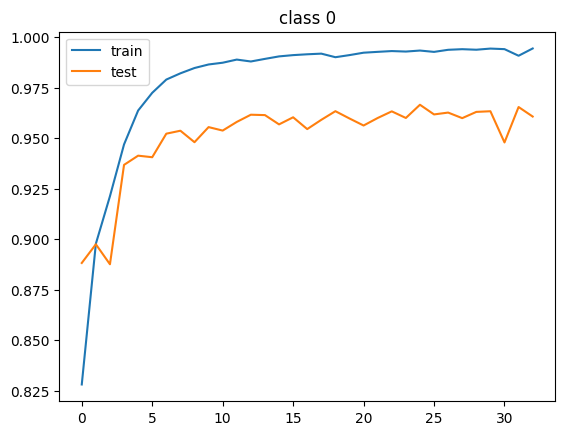

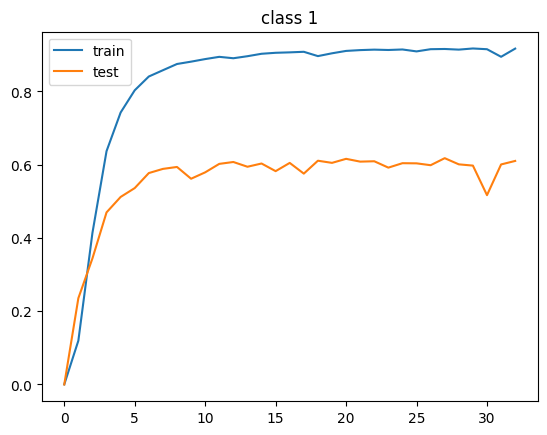

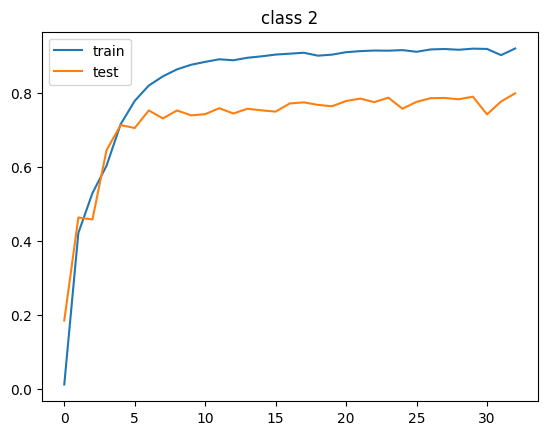

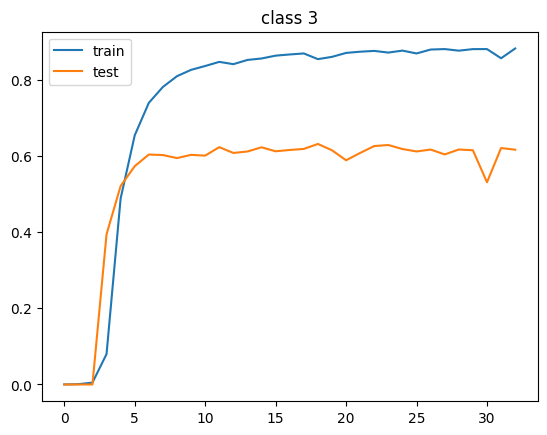

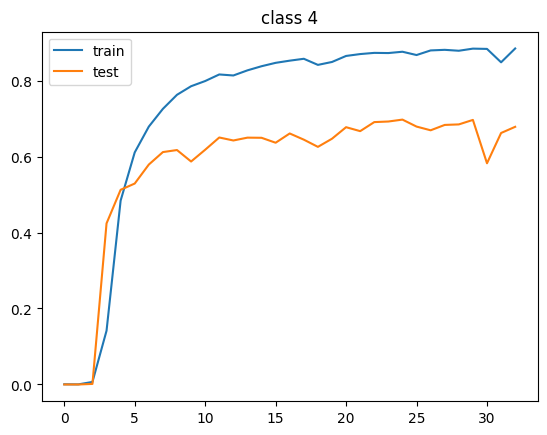

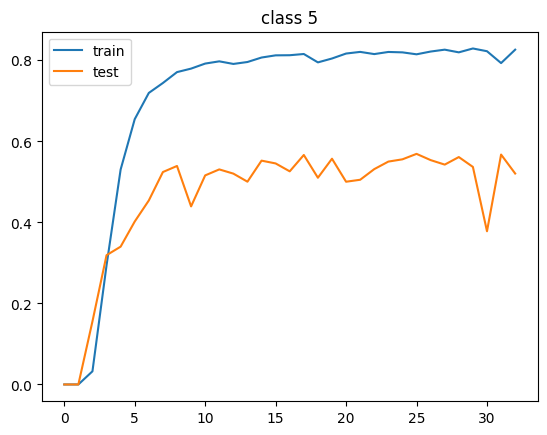

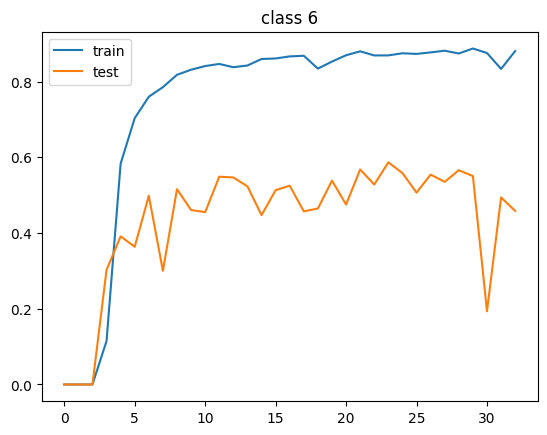

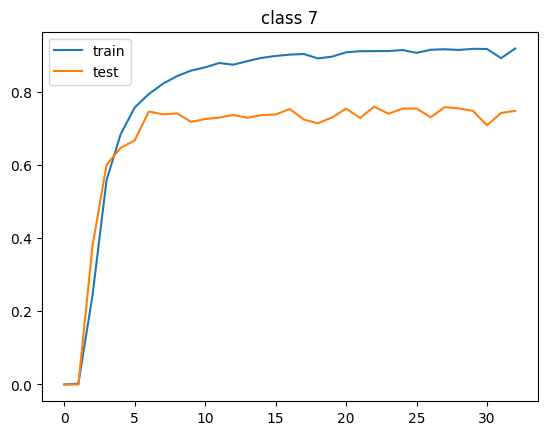

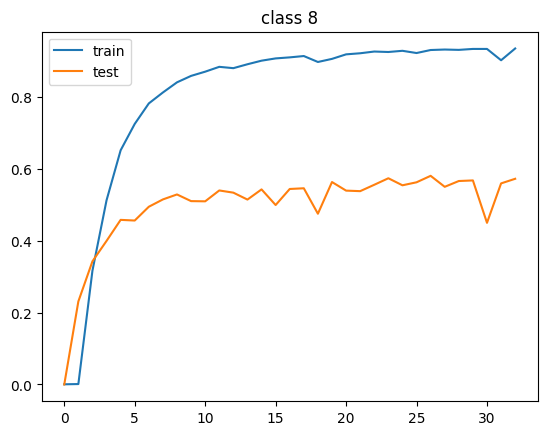

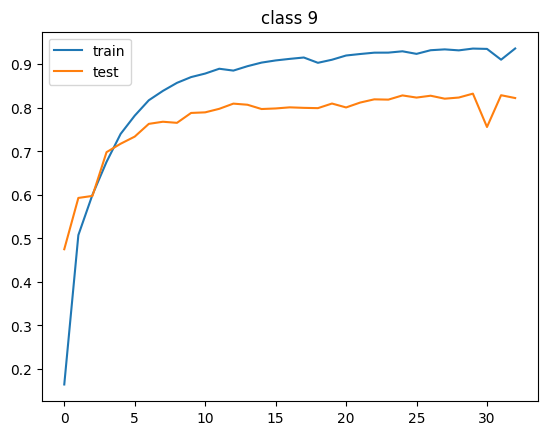

In [ ]:
for i in range(num_classes):
  plt.plot(dice_loss_train_store[:33,i],label='train')
  plt.plot(dice_loss_test_store[:33,i],label='test')
  plt.legend()
  plt.title(f'class {i}')
  plt.show()

In [ ]:
path_to_model = 'model_big_classbalance_3000train_augment_background_mirror_rotate_gaussian_with_weights_bitemperedloss_29epochs_loss_553_1940_train_val_overfittingalotithink_lowestdice_class_score_5_080score_train_6_054_val_5_033_test_070_avg'
model = torch.load(path_to_model)

In [ ]:
## Visualize results

def visualize_results(images, masks, num_examples):
    # Compares visually 'num_examples' of images with the actual and predicted mask

    # Predict masks with the model
    model.eval()
    with torch.no_grad():
        preds = model(images)

    # Take the argmax to get the class label for each pixel
    pred_masks = preds.argmax(dim=1)

    for i in range(num_examples if num_examples < batch_size else batch_size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        img = images[i].detach().cpu().permute((1, 2, 0)).numpy()   #.astype(int)
        cmap = 'gray' if grayscale else None
        ax1.imshow(img, cmap=cmap)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Actual mask
        true_mask = segment_image(images[i], masks[i]).permute((1, 2, 0)).long()
        ax2.imshow(true_mask)
        ax2.set_title('Actual Mask')
        ax2.axis('off')

        # Predicted mask
        pred_mask = segment_image(images[i], pred_masks[i]).permute((1, 2, 0)).long()
        ax3.imshow(pred_mask)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()


# Get a batch of images and masks from the dataloader
print('Train:')
images, masks = next(iter(train_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Validation:')
images, masks = next(iter(validation_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Test:')
images, masks = next(iter(test_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=30)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

def calculate_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true.flatten().detach().cpu().numpy(), y_pred.flatten().detach().cpu().numpy())
    return accuracy


def calculate_dice(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    dice_values = []
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        total = np.sum(y_true == i) + np.sum(y_pred == i)
        dice = (2.0 * intersection + smooth) / (total + smooth)
        dice_values.append(dice)

    return np.mean(dice_values)

# def calculate_dice(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
#     dice_sum = 0.0
#     for i in range(num_classes):
#         true_class = (y_true == i)
#         pred_class = (y_pred == i)
#         intersection = torch.sum(true_class * pred_class)
#         union = torch.sum(true_class) + torch.sum(pred_class)
#         dice = (2.0 * intersection + smooth) / (union + smooth)
#         dice_sum += dice

#     return dice_sum/num_classes


def calculate_iou(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    iou_values = []
    for i in range(num_classes):
        intersection = np.sum(np.logical_and(y_true == i, y_pred == i))
        union = np.sum(np.logical_or(y_true == i, y_pred == i))
        iou = (intersection + smooth) / (union + smooth)
        iou_values.append(iou)

    return np.mean(iou_values)

# def calculate_iou(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
#     iou_sum = 0.0
#     for i in range(num_classes):
#         true_class = (y_true == i)
#         pred_class = (y_pred == i)
#         intersection = torch.sum(true_class * pred_class)
#         union = torch.sum(true_class) + torch.sum(pred_class) - intersection
#         iou = (intersection + smooth) / (union + smooth)
#         iou_sum += iou

#     return iou_sum/num_classes


def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.flatten().detach().cpu().numpy(),
        pred.flatten().detach().cpu().numpy(),
        normalize=normalize,
        labels=np.arange(num_classes)
    )


In [ ]:
## Evaluate test set

# Dice
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False, num_workers=num_workers)

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    dice_scores_ve = []
    #iou_scores = []
    test_dice_scores = np.zeros(num_classes)
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predictions = outputs.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller
        test_accuracies.append(calculate_accuracy(masks, predictions) * len(images))
        dice_scores = dice_coefficient(outputs.argmax(dim=1), masks, num_classes)
        dice_scores_ve.append(calculate_dice(masks, predictions))
        #iou_scores.append(calculate_iou(masks, predictions))
        test_dice_scores += np.nan_to_num(dice_scores)*len(images)

        ccm = compute_confusion_matrix(masks, predictions)
        confusion_matrix += ccm

    test_accuracy = np.sum(test_accuracies) / len(test_dataloader.dataset)
    dice_score_ve = np.mean(dice_scores)
    avg_dice_scores_test = test_dice_scores / len(test_dataloader.dataset)
    #iou_score = np.mean(iou_scores)

    model.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print('Accuracy:', test_accuracy)
print('Dice:', dice_score_ve)
print('Dice for classes:', avg_dice_scores_test)
print('Avg dice:', np.mean(avg_dice_scores_test[1:-1]))
#print('IoU:', iou_score)

Accuracy: 0.8706166585286458
Dice: 0.6874732226133347
Dice for classes: [0.94806033 0.70510894 0.85094923 0.80861533 0.56801182 0.35413566
 0.36535585 0.80691546 0.68167931 0.78590029]
Avg dice: 0.6425964497029781


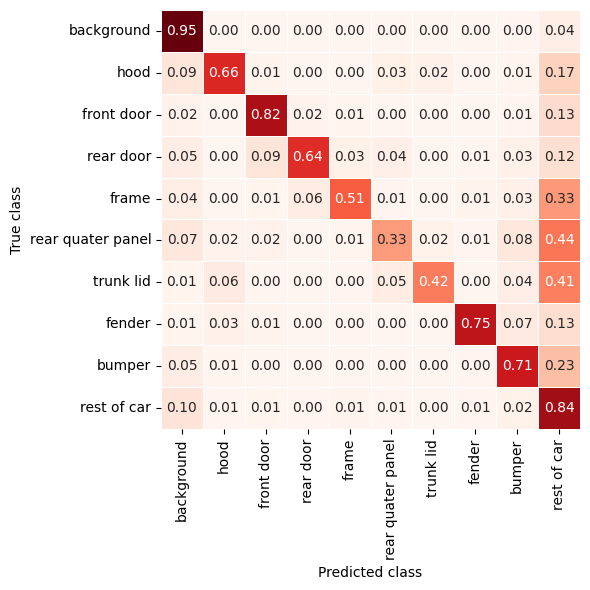

In [ ]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = car_parts
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

In [ ]:
# SÍÐAN TIL ÞESS AÐ FÁ GOTT MAT Á TESTING ACCURACY/DICE SCORE ÞÁ ER KANNSKI HÆGT AÐ NOTA AÐFERÐIR EINS OG Í COMPUTATIONAL TOOLS
# T.D. CROSS VALIDATION EÐA BOOTSTRAP VALIDATION (AÐ ÞVÍ AÐ VIÐ ERUM BARA MEÐ 30 TEST SAMPLES ÞANNIG AÐ ÞAÐ ER VARLA RAUNHÆFT AÐ META
# GÆÐIN BARA Á ÞEIM)